## Download the datasets in Cloud Storage
The dataset is a publickly avaible data via this [CERNBox link](https://cernbox.cern.ch/files/link/public/rcm6wfMI1RDhp2B?tiles-size=1&items-per-page=100&view-mode=resource-table&sort-by=name&sort-dir=asc)

In [ ]:
!curl -L https://cernbox.cern.ch/remote.php/dav/public-files/rcm6wfMI1RDhp2B/qcd_100k.root | gsutil cp - gs://cuda-programming-406720/QCD_LLP_samples/root-files/qcd_100k.root
!curl -L https://cernbox.cern.ch/remote.php/dav/public-files/rcm6wfMI1RDhp2B/test_darkphoton_100k.root | gsutil cp - gs://cuda-programming-406720/QCD_LLP_samples/root-files/test_darkphoton_100k.root


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Copying from <STDIN>...
100 15.3G  100 15.3G    0     0  14.2M      0  0:18:26  0:18:26 --:--:-- 16.2M
/ [1 files][    0.0 B/    0.0 B]      0.0 B/s                                   
Operation completed over 1 objects.                                              
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Copying from <STDIN>...
100 14.2G  100 14.2G    0     0  14.6M      0  0:16:36  0:16:36 --:--:-- 16.8M
/ [1 files][    0.0 B/    0.0 B]      0.0 B/s                                   
Operation completed over 1 objects.                                           

## Settings

In [ ]:
%%capture
!pip install uproot
!pip install sbi
!pip install --upgrade google-cloud-storage

## Data loading

In [ ]:
from sklearn.model_selection import train_test_split
from google.cloud import storage
from io import BytesIO
import uproot
from itertools import chain
import numpy as np
import torch
import h5py
from array import array
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker

In [ ]:
def get_data_from_root(file_dir:str, bucket_name:str = 'cuda-programming-406720'):
  client = storage.Client()
  bucket = client.get_bucket(bucket_name)
  blob = bucket.blob(file_dir)
  file_contents = BytesIO(blob.download_as_string())
  tree = uproot.open(file_contents)
  data = tree['Delphes']
  return data

In [ ]:
signal_file = 'QCD_LLP_samples/root-files/test_darkphoton_100k.root'
background_file = 'QCD_LLP_samples/root-files/qcd_100k.root'

In [ ]:
data_llp = get_data_from_root(signal_file)
d = data_llp['Particle']['Particle.PID'].array()
d = list(chain.from_iterable(d))
np.unique(d)

In [ ]:
from functions import is_valid, is_sm_quark, is_sm_lepton, is_sm_gauge_boson_or_higgs, is_hadron

pids_darkphoton = np.unique(d)
pids_darkphoton_bsm = []
for pid in pids_darkphoton:
  if not (is_sm_quark(pid) or is_sm_lepton(pid) or is_sm_lepton(pid) or is_sm_gauge_boson_or_higgs(pid) or is_hadron(pid)):
    pids_darkphoton_bsm.append(pid)

In [ ]:
pids_darkphoton_bsm

[-4900101,
 1103,
 2101,
 2103,
 2203,
 3103,
 3203,
 4900021,
 4900101,
 9940003,
 9940103]

In [ ]:
from tqdm import tqdm
refs = []
for line in tqdm(data_llp['Track']['Track.Particle'].array()):
  refs.append([element.ref for element in line])

In [ ]:
track_refs = data_llp['Track']['Track.Particle'].array()

particle_pids = data_llp['Particle']['Particle.PID'].array()

print('len of the first line of PIDs',len(particle_pids[0]))
refs[0][100:]

len of the first line of PIDs 1347


[2050,
 2051,
 2061,
 2075,
 2076,
 2095,
 2100,
 2101,
 2104,
 2108,
 2112,
 2116,
 2130,
 2131,
 2132,
 2138,
 2147,
 2168,
 2171,
 2172,
 2174,
 2176,
 2204,
 2209,
 2211,
 2212,
 2213,
 2214,
 2217,
 2218,
 2220,
 2223,
 2224,
 2228,
 2229,
 2230,
 2266,
 2267,
 2268,
 2282,
 2283,
 2317,
 2325,
 2328,
 2333,
 2334,
 2337,
 2340,
 2344,
 2348,
 2374,
 2375,
 2393,
 2455,
 2456,
 2478,
 2479,
 2496,
 2509,
 2517,
 2519,
 2520,
 2521,
 2544,
 2547,
 2551,
 2552,
 2557,
 2558,
 2584,
 2586,
 2600,
 2611,
 2620,
 2634,
 2635,
 2642,
 2652,
 2653,
 2689,
 2762,
 2763,
 2765,
 2774,
 2789,
 2790,
 2794,
 2798,
 2801,
 2823,
 2826,
 2829,
 2846,
 2889,
 2899,
 2911,
 2914,
 2920,
 2921,
 2945,
 2963,
 2984,
 2988,
 3001,
 3031,
 3032,
 3039,
 3046,
 3047,
 3048,
 3049,
 3052,
 3053,
 3062,
 3066,
 3077,
 3082,
 3083,
 3094,
 3095,
 3099,
 3200,
 3216,
 3220,
 3230,
 3232,
 3234,
 3245,
 3246,
 3247,
 3266,
 3267,
 3268,
 3281,
 3282,
 3291,
 3294,
 3297,
 3302,
 3303,
 3305,
 3310,
 3312,

In [ ]:
particle_fUniqueID = data_llp['Particle/Particle.fUniqueID'].array()
particle_fUniqueID

<Array [[1, 2, 3, 4, ..., 1345, 1346, 1347], ...] type='100000 * var * uint32'>

In [ ]:
data_llp['Track/Track.Particle'].array()

<Array [[{ref: 697}, {...}, ..., {...}], ...] type='100000 * var * TRef[ref...'>

In [ ]:
np.where(np.array(particle_fUniqueID[0]) == 697)[0][0]

696

In [ ]:
data_llp['Particle'].keys()

['Particle.fUniqueID',
 'Particle.fBits',
 'Particle.PID',
 'Particle.Status',
 'Particle.IsPU',
 'Particle.M1',
 'Particle.M2',
 'Particle.D1',
 'Particle.D2',
 'Particle.Charge',
 'Particle.Mass',
 'Particle.E',
 'Particle.Px',
 'Particle.Py',
 'Particle.Pz',
 'Particle.P',
 'Particle.PT',
 'Particle.Eta',
 'Particle.Phi',
 'Particle.Rapidity',
 'Particle.T',
 'Particle.X',
 'Particle.Y',
 'Particle.Z']

In [ ]:
PT_particle = data_llp['Particle']['Particle.PT'].array()
PT_track = data_llp['Track']['Track.PT'].array()
PID = data_llp['Particle']['Particle.PID'].array()

In [ ]:
refs = data_llp['Track/Track.Particle'].array()
for i in range(len(refs)):
  for j in range(len(refs[i])):
    ref = refs[i][j].ref
    pid = PID[i][ref]
    if not (is_sm_quark(pid) or
            is_sm_lepton(pid) or
            is_sm_lepton(pid) or
            is_sm_gauge_boson_or_higgs(pid) or
            is_hadron(pid)):
      pt_particle = PT_particle[i][ref]
      pt_track = PT_track[i][ref]
      print(f'PT Particle: {pt_particle} \t PT Track: {pt_track}')

IndexError: cannot slice NumpyArray (of length 1347) with 1359: index 1359 is out of bounds for axis 0 with size 1347

This error occurred while attempting to slice

    <Array [21, 21, 25, 21, 21, ..., -211, 22, 22, 22, 22] type='1347 * int32'>

with

    1359

In [ ]:
len(PID[i])

1347

In [ ]:
print(refs[i][j].ref)

TypeError: only integers, slices (`:`), ellipsis (`...`), np.newaxis (`None`), integer/boolean arrays (possibly with variable-length nested lists or missing values), field name (str) or names (non-tuple iterable of str) are valid indices for slicing, not

    <Record {ref: 697} type='TRef[ref: uint32]'>

This error occurred while attempting to slice

    <Array [{ref: 697}, {...}, ..., {ref: 2613}] type='666 * TRef[ref: uint32]'>

with

    <Record {ref: 697} type='TRef[ref: uint32]'>

In [ ]:
data_llp = get_data_from_root(signal_file)
features = ['Track.PT', 'Track.Eta', 'Track.Phi', 'Track.D0', 'Track.DZ']

signal_data = []
for i in range(5):
  d = data_llp['Track'][features[i]].array().tolist()
  d = list(chain.from_iterable(d))
  signal_data.append(d)
signal_data = torch.tensor(signal_data).T
signal_data = torch.concatenate((signal_data, torch.tensor([[1]]*signal_data.shape[0])), axis=1)
print('Shape of signal dataset:', signal_data.shape)

In [ ]:
from functions import is_valid, is_sm_quark, is_sm_lepton, is_sm_gauge_boson_or_higgs, is_hadron
from tqdm import tqdm

particle_class = []
for line in tqdm(data_llp['Track']['Track.PID'].array()):
  for pid in line:
    if is_valid(pid):
      if (is_sm_quark(pid) or is_sm_lepton(pid) or is_sm_lepton(pid) or is_sm_gauge_boson_or_higgs(pid) or is_hadron(pid)):
        particle_class.append('SM')
      else:
        particle_class.append('BSM')
    else:
      print(f'Invalid pid: {pid}')

100%|██████████| 100000/100000 [25:09<00:00, 66.26it/s]


In [ ]:
from collections import Counter
particle_class = np.array(particle_class)
counts = Counter(particle_class)
# [('SM', counts.get('SM')*100/counts.total()), ('BSM', counts.get('BSM')*100/counts.total())]
print(counts)

Counter({'SM': 78848594})


In [ ]:
# sm_particles = [
#             21, 22, 23, 24, 25, 32, 33, 34, 35, 36, 37, # Gauge and higg bosons
#             2, 1, 4, 3, 6, 5, 7, 8,  # Quarks;
#             11, 12, 13, 14, 15, 16, 17, 18  # Leptons
# ]

<!-- Standard Model (SM) Particles include:
* Gauge Bosons

  - Photon ($\gamma$) – PID: 22
  - W bosons ($W^+, W^-$) – PIDs: 24, -24
  - Z boson ($Z^0$) – PID: 23
  - Gluons ($g$) – PID: 21

* Fermions
* Quarks
  - Up (u) – PID: 2
  - Down (d) – PID: 1
  - Charm (c) – PID: 4
  - Strange (s) – PID: 3
  - Top (t) – PID: 6
  - Bottom (b) – PID: 5
* Leptons
  - Electron ($e^−$) – PID: 11
  - Electron neutrino ($ν_e$​) – PID: 12
  - Muon ($μ^−$) – PID: 13
  - Muon neutrino ($ν_μ$​) – PID: 14
  - Tau ($τ^−$) – PID: 15
  - Tau neutrino ($ν_τ$​) – PID: 16 -->

  🔴 The following cell will take around 40min to run 😏



In [ ]:
# from particle import Particle
# from tqdm import tqdm

# sm_particles = [
#             21, 22, 23, 24, 25, 32, 33, 34, 35, 36, 37, # Gauge and higg bosons
#             2, 1, 4, 3, 6, 5, 7, 8,  # Quarks
#             11, 12, 13, 14, 15, 16, 17, 18  # Leptons
# ]


# def classify_particle(pid):
#         if abs(pid) in sm_particles:
#             return 'SM'
#         else:
#             return 'BSM'

# particle_class = []
# for line in tqdm(data_llp['Track']['Track.PID'].array()):
#   for pid in line:
#     class_ = classify_particle(pid)
#     particle_class.append(class_)

In [ ]:
# from collections import Counter
# particle_class = np.array(particle_class)
# counts = Counter(particle_class)
# [('SM', counts.get('SM')*100/counts.total()), ('BSM', counts.get('BSM')*100/counts.total())]

In [ ]:
data_sm1 = signal_data[particle_class == 'SM', :]
data_bsm1 = signal_data[particle_class == 'BSM', :]

In [ ]:
data_sm1.shape

torch.Size([78848594, 6])

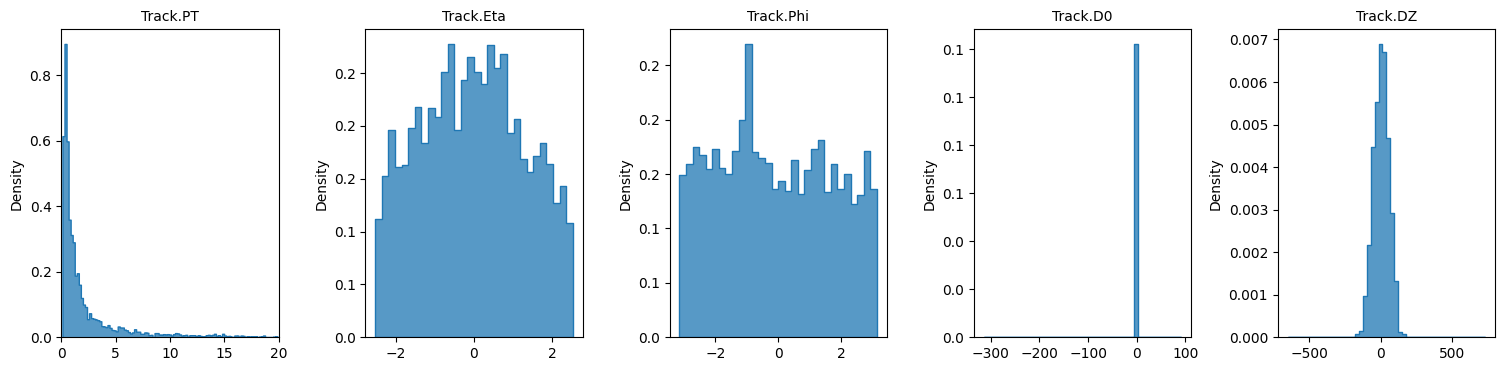

In [ ]:
fig,axes = plt.subplots(1,5, figsize=(18.5,4))
plot_hists(d=data_sm[:5000,:], axes=axes, bins = [500,30,30,50,50])
# plt.savefig('plots/bkg_hists.pdf', format='pdf')
plt.show()

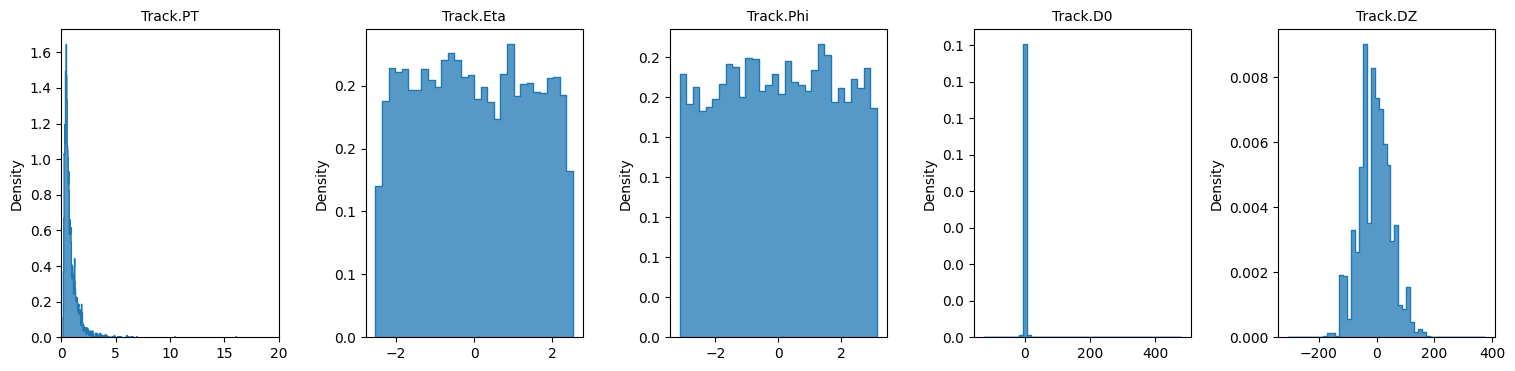

In [ ]:
fig,axes = plt.subplots(1,5, figsize=(18.5,4))
plot_hists(d=data_bsm[:5000,:], axes=axes, bins = [500,30,30,50,50])
# plt.savefig('plots/bkg_hists.pdf', format='pdf')
plt.show()

In [ ]:
del data_llp

In [ ]:
def plot_hists(d, axes, bins):
  for i in range(5):
    sns.histplot(x=d[:,i], ax=axes[i], bins=bins[i], element='step', fill=True, stat='density')
    axes[i].set_title(features[i], fontsize=10)
    axes[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    axes[i].set_xlabel('')
  axes[0].set_xlim((0,20))
  # axes[3].set_xlim((-2,5))
  plt.subplots_adjust(hspace=0.2, wspace=0.4)
  axes[4].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

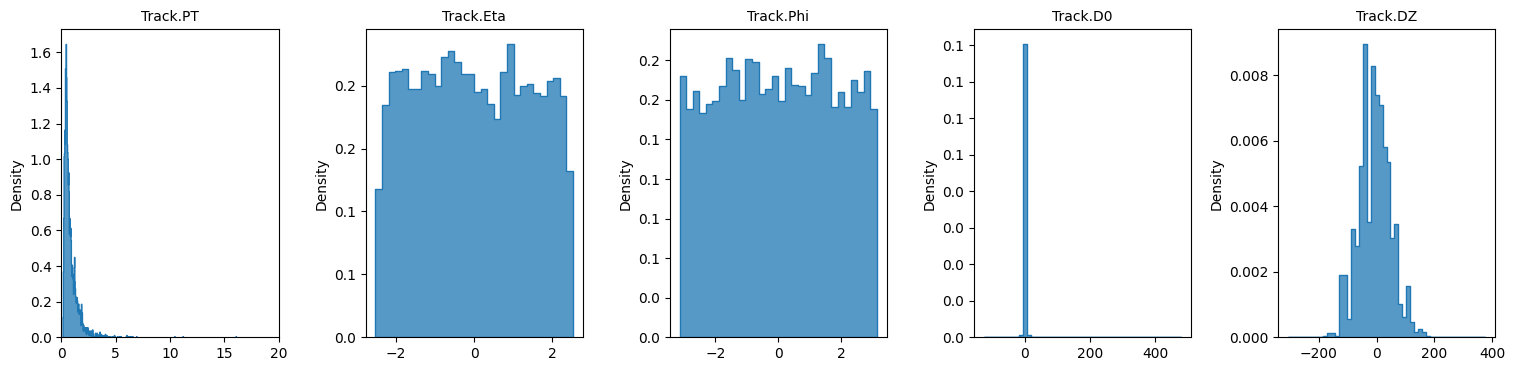

In [ ]:
fig,axes = plt.subplots(1,5, figsize=(18.5,4))
d_sig = signal_data[:5000,:]
plot_hists(d=d_sig, axes=axes, bins = [500,30,30,50,50])
# plt.savefig('plots/bkg_hists.pdf', format='pdf')
plt.show()

In [ ]:
data_qcd = get_data_from_root(background_file)
d = data_qcd['Particle']['Particle.PID'].array()
d = list(chain.from_iterable(d))
np.unique(d)

array([ -20433,  -20423,  -20413,  -20313,  -20213,  -10411,  -10323,
        -10321,  -10313,  -10311,   -5132,   -5122,   -4232,   -4224,
         -4222,   -4214,   -4132,   -4122,   -4114,   -3334,   -3324,
         -3322,   -3314,   -3312,   -3224,   -3222,   -3214,   -3212,
         -3122,   -3114,   -3112,   -2224,   -2214,   -2212,   -2114,
         -2112,   -1114,    -533,    -531,    -523,    -521,    -513,
          -511,    -433,    -431,    -423,    -421,    -415,    -413,
          -411,    -325,    -323,    -321,    -313,    -311,    -213,
          -211,     -16,     -15,     -14,     -13,     -12,     -11,
            -5,      -4,      -3,      -2,      -1,       1,       2,
             3,       4,       5,      11,      12,      13,      14,
            15,      16,      21,      22,     111,     113,     130,
           211,     213,     221,     223,     225,     310,     311,
           313,     321,     323,     325,     331,     333,     411,
           413,     

In [ ]:
data_qcd = get_data_from_root(background_file)
features = ['Track.PT', 'Track.Eta', 'Track.Phi', 'Track.D0', 'Track.DZ']

background_data = []
for i in range(5):
  d = data_qcd['Track'][features[i]].array().tolist()
  d = list(chain.from_iterable(d))
  background_data.append(d)
background_data = torch.tensor(background_data).T
background_data = torch.concatenate((background_data, torch.tensor([[0]]*background_data.shape[0])), axis=1)
print('Shape of background dataset:', background_data.shape)

Shape of background dataset: torch.Size([81971289, 6])


In [ ]:
from functions import is_valid, is_sm_quark, is_sm_lepton, is_sm_gauge_boson_or_higgs, is_hadron
from tqdm import tqdm

particle_class = []
for line in tqdm(data_qcd['Track']['Track.PID'].array()):
  for pid in line:
    if is_valid(pid):
      if (is_sm_quark(pid) or is_sm_lepton(pid) or is_sm_lepton(pid) or is_sm_gauge_boson_or_higgs(pid) or is_hadron(pid)):
        particle_class.append('SM')
      else:
        particle_class.append('BSM')
    else:
      raise(f'Invalid pid: {pid}')

particle_class = np.array(particle_class)
counts = Counter(particle_class)
print(counts)

100%|██████████| 100000/100000 [25:58<00:00, 64.18it/s]


Counter({'SM': 81971289})


In [ ]:
from collections import Counter
particle_class = np.array(particle_class)
counts = Counter(particle_class)
print(counts)

Counter({'SM': 81971289})


In [ ]:
# particle_class = []
# for line in tqdm(data_qcd['Track']['Track.PID'].array()):
#   for pid in line:
#     class_ = classify_particle(pid)
#     particle_class.append(class_)

# particle_class = np.array(particle_class)
# counts = Counter(particle_class)
# [('SM', counts.get('SM')*100/counts.total()), ('BSM', counts.get('BSM')*100/counts.total())]

NameError: name 'data_qcd' is not defined

In [ ]:
data_sm2 = background_data[particle_class == 'SM', :]
data_bsm2 = background_data[particle_class == 'BSM', :]

In [ ]:
del data_qcd

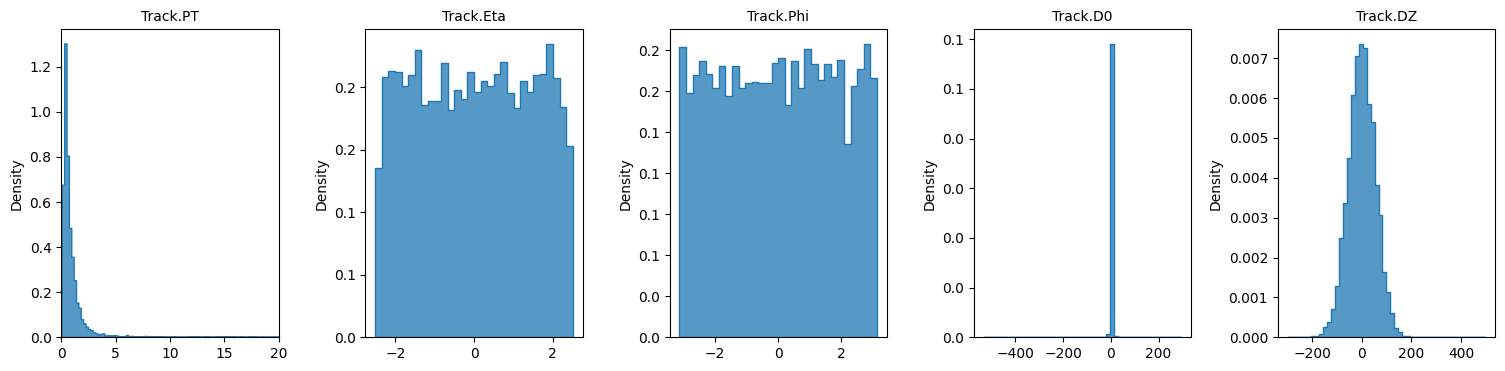

In [ ]:
fig,axes = plt.subplots(1,5, figsize=(18.5,4))
d_bkg = background_data[:5000,:]
plot_hists(d=d_bkg, axes=axes, bins = [700,30,30,50,50])
# plt.savefig('plots/bkg_hists.pdf', format='pdf')
plt.show()

In [ ]:
indexes = np.random.choice(range(data_sm2.shape[0]), size=data_bsm.shape[0], replace=False)
data_sm2 = data_sm2[indexes,:]

In [ ]:
data_sm.shape

torch.Size([866248, 6])

In [ ]:
data = np.concatenate((data_sm2, data_bsm))
data.shape

(155964692, 6)

In [ ]:
d_sig = data_bsm[:5000,:]
d_bkg = data_sm2[:5000,:]

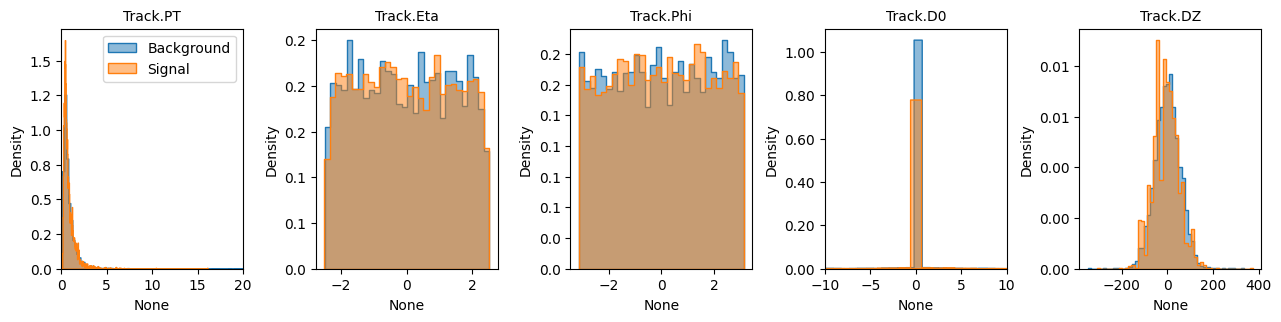

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(20, 4))
bins = [500,30,30,500,50]
for i in range(5):
  sns.histplot(x=d_bkg[:,i], ax=axes[i], bins=bins[i],
               element='step', fill=True, stat='density', label="Background", alpha=0.5)
  sns.histplot(x=d_sig[:,i], ax=axes[i], bins=bins[i],
               element='step', fill=True, stat='density', label="Signal", alpha=0.5)
  axes[i].set_title(features[i], fontsize=10)
  axes[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# plt.subplots_adjust(hspace=0.2, wspace=0.4)
axes[0].legend()
axes[0].set_xlim((0,20))
axes[3].set_xlim((-10,10))
axes[3].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
axes[4].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
fig.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2, hspace=0.2, wspace=0.4)
# plt.savefig('plots/data_hists.pdf', format='pdf')
plt.show()

In [ ]:
def print_desc_stats(data):
  print(f'min: {data.min():.2f}\t max: {data.max():.2f}\t mean: {data.mean():.2f}\t std: {data.std():.2f}')

print('======Descriptive statistics for the full dataset======')
for i in range(5):
  print(features[i], end='\t>> ')
  print_desc_stats(data[:,i])

print('\n======Descriptive statistics for signal dataset======')
for i in range(5):
  print(features[i], end='\t>> ')
  print_desc_stats(data_sm[:,i])

print('\n======Descriptive statistics for background dataset======')
for i in range(5):
  print(features[i], end='\t>> ')
  print_desc_stats(data_bsm2[:,i])

======Descriptive statistics for the full dataset======
Track.PT	>> min: 0.05	 max: 1255.26	 mean: 0.98	 std: 2.51
Track.Eta	>> min: -2.95	 max: 2.96	 mean: -0.00	 std: 1.42
Track.Phi	>> min: -3.14	 max: 3.14	 mean: 0.00	 std: 1.81
Track.D0	>> min: -1310.36	 max: 1276.58	 mean: -0.00	 std: 7.54
Track.DZ	>> min: -5805.83	 max: 5623.76	 mean: -0.00	 std: 56.10

======Descriptive statistics for signal dataset======
Track.PT	>> min: 0.08	 max: 144.43	 mean: 2.81	 std: 5.83
Track.Eta	>> min: -2.55	 max: 2.54	 mean: -0.05	 std: 1.31
Track.Phi	>> min: -3.14	 max: 3.14	 mean: -0.06	 std: 1.80
Track.D0	>> min: -952.80	 max: 884.08	 mean: -0.01	 std: 7.29
Track.DZ	>> min: -2026.63	 max: 3747.13	 mean: 0.06	 std: 54.88

======Descriptive statistics for background dataset======
Track.PT	>> 

RuntimeError: min(): Expected reduction dim to be specified for input.numel() == 0. Specify the reduction dim with the 'dim' argument.

In [ ]:
# @title split the dataset
X = data[:,:5]
y = data[:,-1]
X_train, X_remain, y_train, y_remain  = train_test_split(
    X,y, test_size=0.2, random_state=45
    )
X_valid, X_test, y_valid, y_test = train_test_split(
    X_remain, y_remain, test_size=0.5, random_state=45
    )

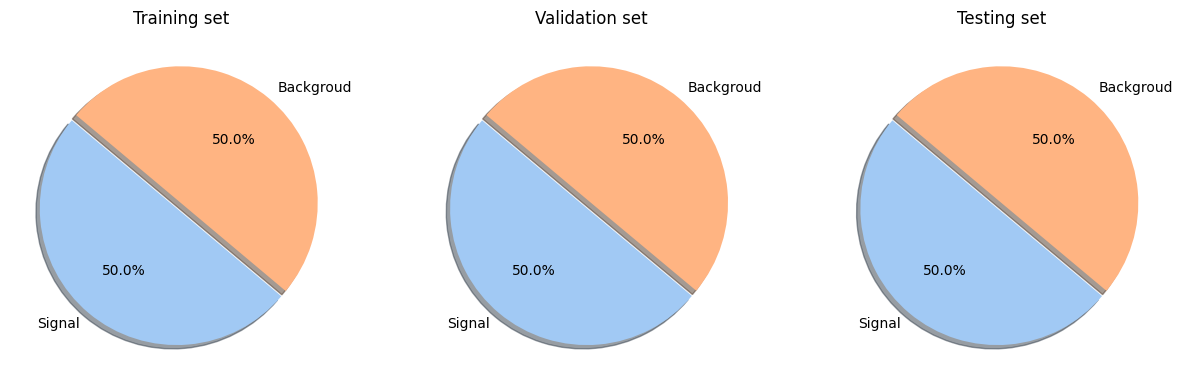

In [ ]:
data_pie_train = pd.DataFrame({
    'label': ['Signal', 'Backgroud'],
    'frequency': [(y_train==1).sum(), (y_train==0).sum()]
    })
data_pie_valid = pd.DataFrame({
    'label': ['Signal', 'Backgroud'],
    'frequency': [(y_valid==1).sum(), (y_valid==0).sum()]
    })
data_pie_test = pd.DataFrame({
    'label': ['Signal', 'Backgroud'],
    'frequency': [(y_test==1).sum(), (y_test==0).sum()]
    })

fig, axes = plt.subplots(1,3, figsize=(15,5))
colors = sns.color_palette('pastel')
axes[0].pie(data_pie_train['frequency'], labels=data_pie_train['label'], colors=colors,
        autopct='%1.1f%%', startangle=140, shadow=True, explode=[0.05, 0.0])
axes[0].set_title('Training set')

axes[1].pie(data_pie_valid['frequency'], labels=data_pie_valid['label'], colors=colors,
        autopct='%1.1f%%', startangle=140, shadow=True, explode=[0.05, 0.0])
axes[1].set_title('Validation set')

axes[2].pie(data_pie_test['frequency'], labels=data_pie_test['label'], colors=colors,
        autopct='%1.1f%%', startangle=140, shadow=True, explode=[0.05, 0.0])
axes[2].set_title('Testing set')
plt.show()

In [ ]:
def export_data_to_h5(X_train, y_train, X_test,y_test, X_valid,y_valid, output_file):
    with h5py.File(output_file, 'w') as f:
      dset = f.create_dataset('X_train', data=X_train, dtype='f')
      dset = f.create_dataset('y_train', data=y_train, dtype='f')
      dset = f.create_dataset('X_valid', data=X_valid, dtype='f')
      dset = f.create_dataset('y_valid', data=y_valid, dtype='f')
      dset = f.create_dataset('X_test', data=X_test, dtype='f')
      dset = f.create_dataset('y_test', data=y_test, dtype='f')
    print(f"Data has been written to {output_file}")

export_data_to_h5(X_train,y_train,
                  X_test,y_test,
                  X_valid,y_valid,
                  output_file='preprocessed_data3.h5')

Data has been written to preprocessed_data3.h5


In [ ]:
!gsutil cp preprocessed_data3.h5 gs://cuda-programming-406720/QCD_LLP_samples/preprocessed_data3.h5
!rm preprocessed_data3.h5

Copying file://preprocessed_data3.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/3.5 GiB.                                      


### Background data

In [ ]:
# Background dataset
def get_data_from_root(file_dir:str, bucket_name:str = 'cuda-programming-406720'):
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(file_dir)
        file_contents = BytesIO(blob.download_as_string())
        tree = uproot.open(file_contents)
        data = tree['Delphes']
        return data
print('reading background data .....')
data_file = 'QCD_LLP_samples/root-files/qcd_100k.root'
data = get_data_from_root(data_file)
features = ['Track.PT', 'Track.Eta', 'Track.Phi', 'Track.D0', 'Track.DZ']

data_bkg = []
for i in range(5):
  d = data['Track'][features[i]].array().tolist()
  d = list(chain.from_iterable(d))
  data_bkg.append(d)
data_bkg = torch.tensor(data_bkg).T
data_bkg = torch.concatenate((data_bkg, torch.tensor([[0]]*data_bkg.shape[0])), axis=1)
print('Shape of background dataset:', data_bkg.shape)

reading background data .....
Shape of background dataset: torch.Size([81971289, 6])


In [ ]:
del data, d

In [ ]:
data_bkg = data_bkg.detach().numpy()

In [ ]:
def plot_hists(d, axes, bins):
  for i in range(5):
    sns.histplot(x=d[:,i], ax=axes[i], bins=bins[i], element='step', fill=True, stat='density')
    axes[i].set_title(features[i], fontsize=10)
    axes[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    axes[i].set_xlabel('')
  axes[0].set_xlim((0,20))
  # axes[3].set_xlim((-2,5))
  plt.subplots_adjust(hspace=0.2, wspace=0.4)
  axes[4].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))

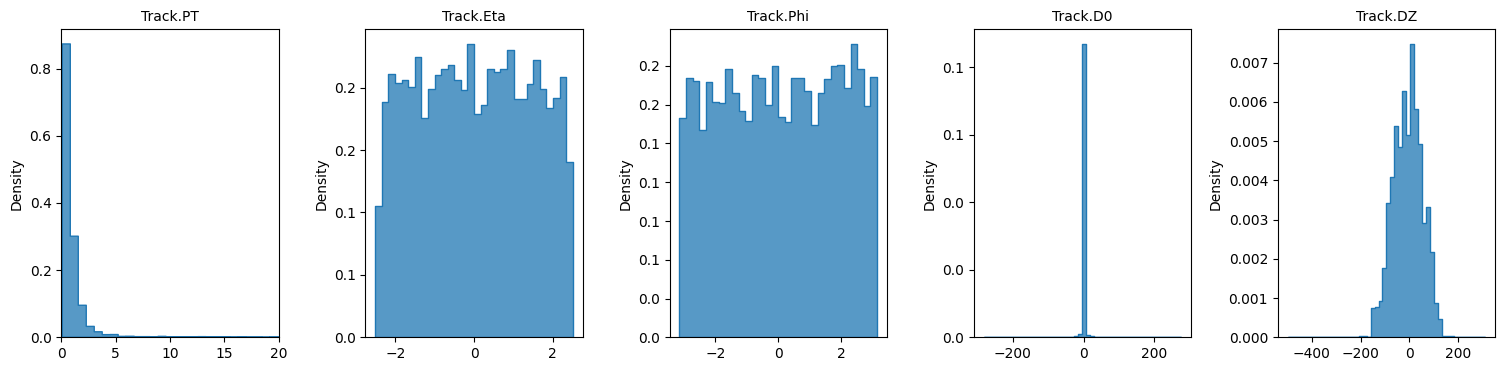

In [ ]:
fig,axes = plt.subplots(1,5, figsize=(18.5,4))
d = data_bkg[:5000,:]
plot_hists(d=d, axes=axes, bins = [500,30,30,50,50])
plt.savefig('plots/bkg_hists.pdf', format='pdf')
plt.show()

### Signal data

In [ ]:
# Signal dataset
def get_data_from_h5(file_dir:str, bucket_name:str = 'cuda-programming-406720'):
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(file_dir)
        file_contents = BytesIO(blob.download_as_string())
        with h5py.File(file_contents, 'r') as f:
            dataset = f['Track']
            d = dataset[:]
        return d
print('reading signal data .....')
data_sig1 = get_data_from_h5('QCD_LLP_samples/h5-files/500GeV_n3_events_100k_1mm_pileup.h5')
data_sig2 = get_data_from_h5('QCD_LLP_samples/h5-files/100GeV_n3_events_100k_1mm_pileup.h5')
data_sig = np.concatenate((data_sig1,data_sig2))
data_sig = torch.tensor([list(data_sig[i]) for i in range(data_sig.shape[0])])

data_sig = torch.concatenate((data_sig, torch.tensor([[1]]*data_sig.shape[0])), axis=1)
print('Shape of signal dataset:', data_sig.shape)

reading signal data .....
Shape of signal dataset: torch.Size([60000000, 6])


In [ ]:
del data_sig1, data_sig2

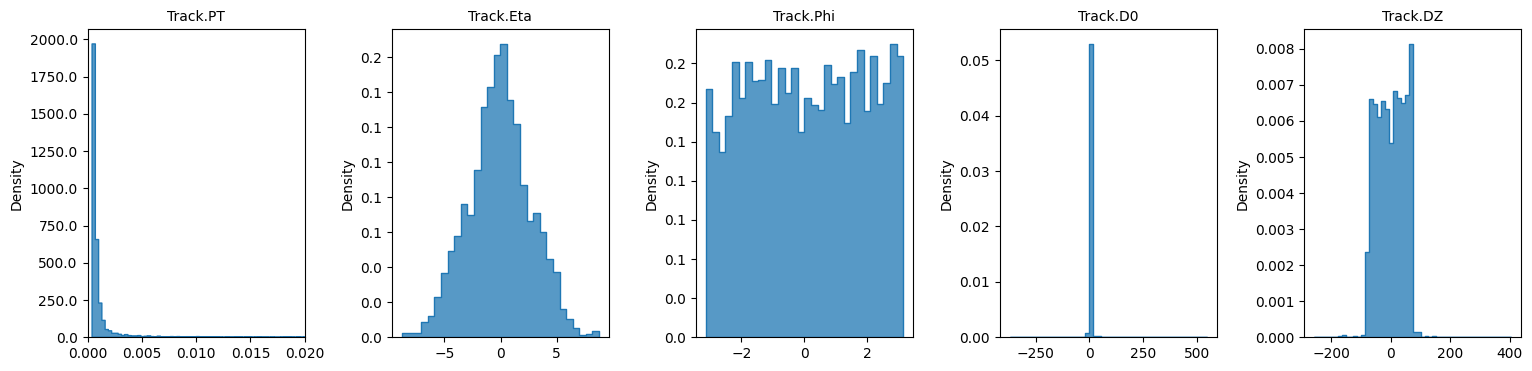

In [ ]:
fig,axes = plt.subplots(1,5, figsize=(18.5,4))
d = data_sig[:5000,:]
plot_hists(d=d, axes=axes, bins = [500,30,30,50,50])
axes[0].set_xlim((0,0.02))
axes[3].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.savefig('plots/sig_hists.pdf', format='pdf')
plt.show()

### Entire dataset

In [ ]:
data = np.concatenate((data_bkg, data_sig))

In [ ]:
indexes = np.random.choice(range(data.shape[0]), size=100_000, replace=False)
d = data[indexes,:]

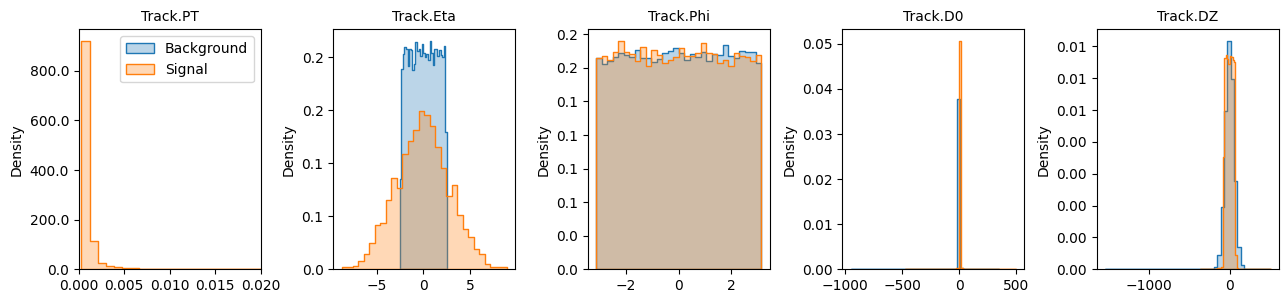

In [ ]:
fig, axes = plt.subplots(1,5, figsize=(20, 4))
bins = [100,30,30,50,50]
for i in range(5):
  sns.histplot(x=d[d[:,-1]==0,i], ax=axes[i], bins=bins[i],
               element='step', fill=True, stat='density', label="Background", alpha=0.3)
  sns.histplot(x=d[d[:,-1]==1,i], ax=axes[i], bins=bins[i],
               element='step', fill=True, stat='density', label="Signal", alpha=0.3)
  axes[i].set_title(features[i], fontsize=10)
  axes[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# plt.subplots_adjust(hspace=0.2, wspace=0.4)
axes[0].legend()
axes[0].set_xlim((0,0.02))
axes[3].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
axes[4].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
fig.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2, hspace=0.2, wspace=0.4)
plt.savefig('plots/data_hists.pdf', format='pdf')
plt.show()

In [ ]:
data.shape

(141971289, 6)

In [ ]:
def print_desc_stats(data):
  print(f'min: {data.min():.2f}\t max: {data.max():.2f}\t mean: {data.mean():.2f}\t std: {data.std():.2f}')

print('======Descriptive statistics for the full dataset======')
for i in range(5):
  print(features[i], end='\t>> ')
  print_desc_stats(data[:,i])

print('\n======Descriptive statistics for signal dataset======')
for i in range(5):
  print(features[i], end='\t>> ')
  print_desc_stats(data_sig[:,i])

print('\n======Descriptive statistics for background dataset======')
for i in range(5):
  print(features[i], end='\t>> ')
  print_desc_stats(data_bkg[:,i])

======Descriptive statistics for the full dataset======
Track.PT	>> min: 0.00	 max: 1255.26	 mean: 0.65	 std: 2.63
Track.Eta	>> min: -9.51	 max: 9.49	 mean: -0.03	 std: 2.14
Track.Phi	>> min: -3.14	 max: 3.14	 mean: 0.00	 std: 1.81
Track.D0	>> min: -1310.36	 max: 1276.58	 mean: -0.03	 std: 8.75
Track.DZ	>> min: -5782.40	 max: 5623.76	 mean: -0.09	 std: 51.83

======Descriptive statistics for signal dataset======
Track.PT	>> min: 0.00	 max: 0.22	 mean: 0.00	 std: 0.00
Track.Eta	>> min: -9.51	 max: 9.49	 mean: -0.07	 std: 2.85
Track.Phi	>> min: -3.14	 max: 3.14	 mean: 0.00	 std: 1.81
Track.D0	>> min: -642.09	 max: 603.12	 mean: -0.08	 std: 10.28
Track.DZ	>> min: -714.24	 max: 770.12	 mean: -0.20	 std: 45.50

======Descriptive statistics for background dataset======
Track.PT	>> min: 0.05	 max: 1255.26	 mean: 1.13	 std: 3.38
Track.Eta	>> min: -2.95	 max: 2.92	 mean: -0.00	 std: 1.42
Track.Phi	>> min: -3.14	 max: 3.14	 mean: 0.00	 std: 1.81
Track.D0	>> min: -1310.36	 max: 1276.58	 mean: -0.

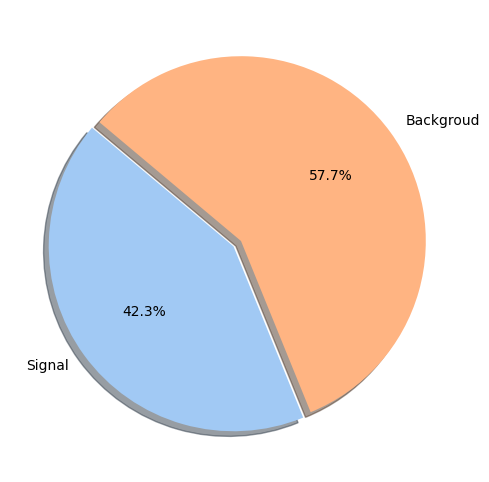

In [ ]:
data_pie = pd.DataFrame({
    'label': ['Signal', 'Backgroud'],
    'frequency': [data_sig.shape[0], data_bkg.shape[0]]
    })

# Choose a Seaborn color palette
colors = sns.color_palette('pastel')
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(data_pie['frequency'], labels=data_pie['label'], colors=colors,
        autopct='%1.1f%%', startangle=140, shadow=True, explode=[0.05, 0.0])
# plt.title('Sample Pie Chart')
plt.savefig('plots/pie_plot.pdf', format='pdf')
plt.show()

## Split the dataset

In [ ]:
X = data[:,:5]
y = data[:,-1]
X_train, X_remain, y_train, y_remain  = train_test_split(
    X,y, test_size=0.2, random_state=45
    )
X_valid, X_test, y_valid, y_test = train_test_split(
    X_remain, y_remain, test_size=0.5, random_state=45
    )

In [ ]:
data_pie_train = pd.DataFrame({
    'label': ['Signal', 'Backgroud'],
    'frequency': [(y_train==1).sum(), (y_train==0).sum()]
    })
data_pie_valid = pd.DataFrame({
    'label': ['Signal', 'Backgroud'],
    'frequency': [(y_valid==1).sum(), (y_valid==0).sum()]
    })
data_pie_test = pd.DataFrame({
    'label': ['Signal', 'Backgroud'],
    'frequency': [(y_test==1).sum(), (y_test==0).sum()]
    })

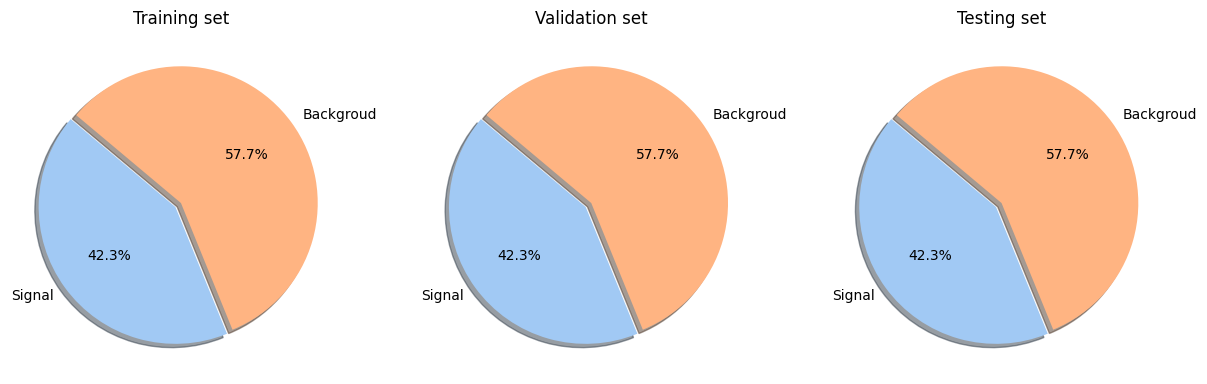

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].pie(data_pie_train['frequency'], labels=data_pie_train['label'], colors=colors,
        autopct='%1.1f%%', startangle=140, shadow=True, explode=[0.05, 0.0])
axes[0].set_title('Training set')

axes[1].pie(data_pie_valid['frequency'], labels=data_pie_valid['label'], colors=colors,
        autopct='%1.1f%%', startangle=140, shadow=True, explode=[0.05, 0.0])
axes[1].set_title('Validation set')

axes[2].pie(data_pie_test['frequency'], labels=data_pie_test['label'], colors=colors,
        autopct='%1.1f%%', startangle=140, shadow=True, explode=[0.05, 0.0])
axes[2].set_title('Testing set')
plt.show()

## Save the datasets spliited into Cloud Storage

In [ ]:
def export_data_to_h5(X_train, y_train, X_test,y_test, X_valid,y_valid, output_file):
    with h5py.File(output_file, 'w') as f:
      dset = f.create_dataset('X_train', data=X_train, dtype='f')
      dset = f.create_dataset('y_train', data=y_train, dtype='f')
      dset = f.create_dataset('X_valid', data=X_valid, dtype='f')
      dset = f.create_dataset('y_valid', data=y_valid, dtype='f')
      dset = f.create_dataset('X_test', data=X_test, dtype='f')
      dset = f.create_dataset('y_test', data=y_test, dtype='f')
    print(f"Data has been written to {output_file}")

export_data_to_h5(X_train,y_train,
                  X_test,y_test,
                  X_valid,y_valid,
                  output_file='preprocessed_data.h5')

Data has been written to preprocessed_data.h5


In [ ]:
!gsutil cp preprocessed_data.h5 gs://cuda-programming-406720/QCD_LLP_samples/preprocessed_data.h5
!rm preprocessed_data.h5

Copying file://preprocessed_data.h5 [Content-Type=application/x-hdf5]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/3.2 GiB.                                      


# PCA

In [ ]:
from google.cloud import storage
from io import BytesIO
import h5py

def get_data_from_cloud(file_dir:str = 'QCD_LLP_samples/preprocessed_data2.h5',
                     bucket_name:str = 'cuda-programming-406720'):
  client = storage.Client()
  bucket = client.get_bucket(bucket_name)
  blob = bucket.blob(file_dir)
  file_contents = BytesIO(blob.download_as_string())
  with h5py.File(file_contents, 'r') as f:
    X_train = f['X_train'][:]
    y_train = f['y_train'][:]
    X_valid = f['X_valid'][:]
    y_valid = f['y_valid'][:]
    X_test = f['X_test'][:]
    y_test = f['y_test'][:]

  return X_train,y_train, X_valid, y_valid, X_test, y_test

X_train,y_train, X_valid, y_valid, X_test, y_test = get_data_from_cloud()

In [ ]:
import pandas as pd

df = pd.DataFrame({
    'PT': X_train[:50_000,0].tolist(),
    'Eta': X_train[:50_000,1].tolist(),
    'Phi': X_train[:50_000,2].tolist(),
    'D0': X_train[:50_000,3].tolist(),
    'DZ': X_train[:50_000,4].tolist()
})
df.head()

,PT,Eta,Phi,D0,DZ
0,1.376281,0.267968,-1.539553,-0.000000e+00,86.629959
1,1.915954,-1.228328,-1.622584,0.000000e+00,-8.718329
2,0.659674,-2.079367,-1.212088,1.386230e-02,23.331472
3,2.082057,-1.983795,0.710464,0.000000e+00,19.183764
4,0.267514,0.503515,-1.121790,-2.976083e-09,-22.057697


In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

In [ ]:
data_scaled.shape

(50000, 5)

In [ ]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=5)  # Reduce to 2 components for visualization
principal_components = pca.fit_transform(data_scaled)

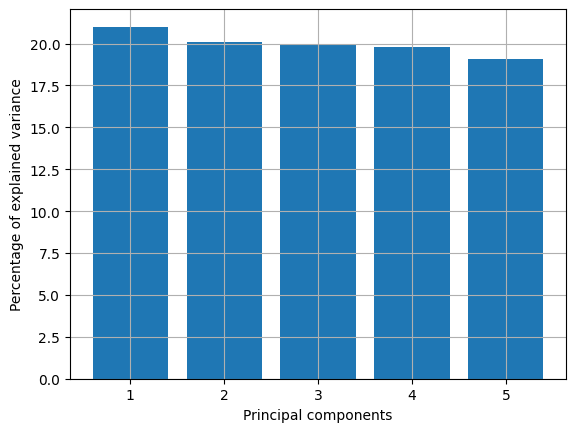

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(1, len(pca.explained_variance_ratio_) + 1),
        pca.explained_variance_ratio_*100/pca.explained_variance_ratio_.sum())
# plt.ylim((18,21))
plt.xlabel('Principal components')
plt.ylabel('Percentage of explained variance')
plt.grid()
plt.show()

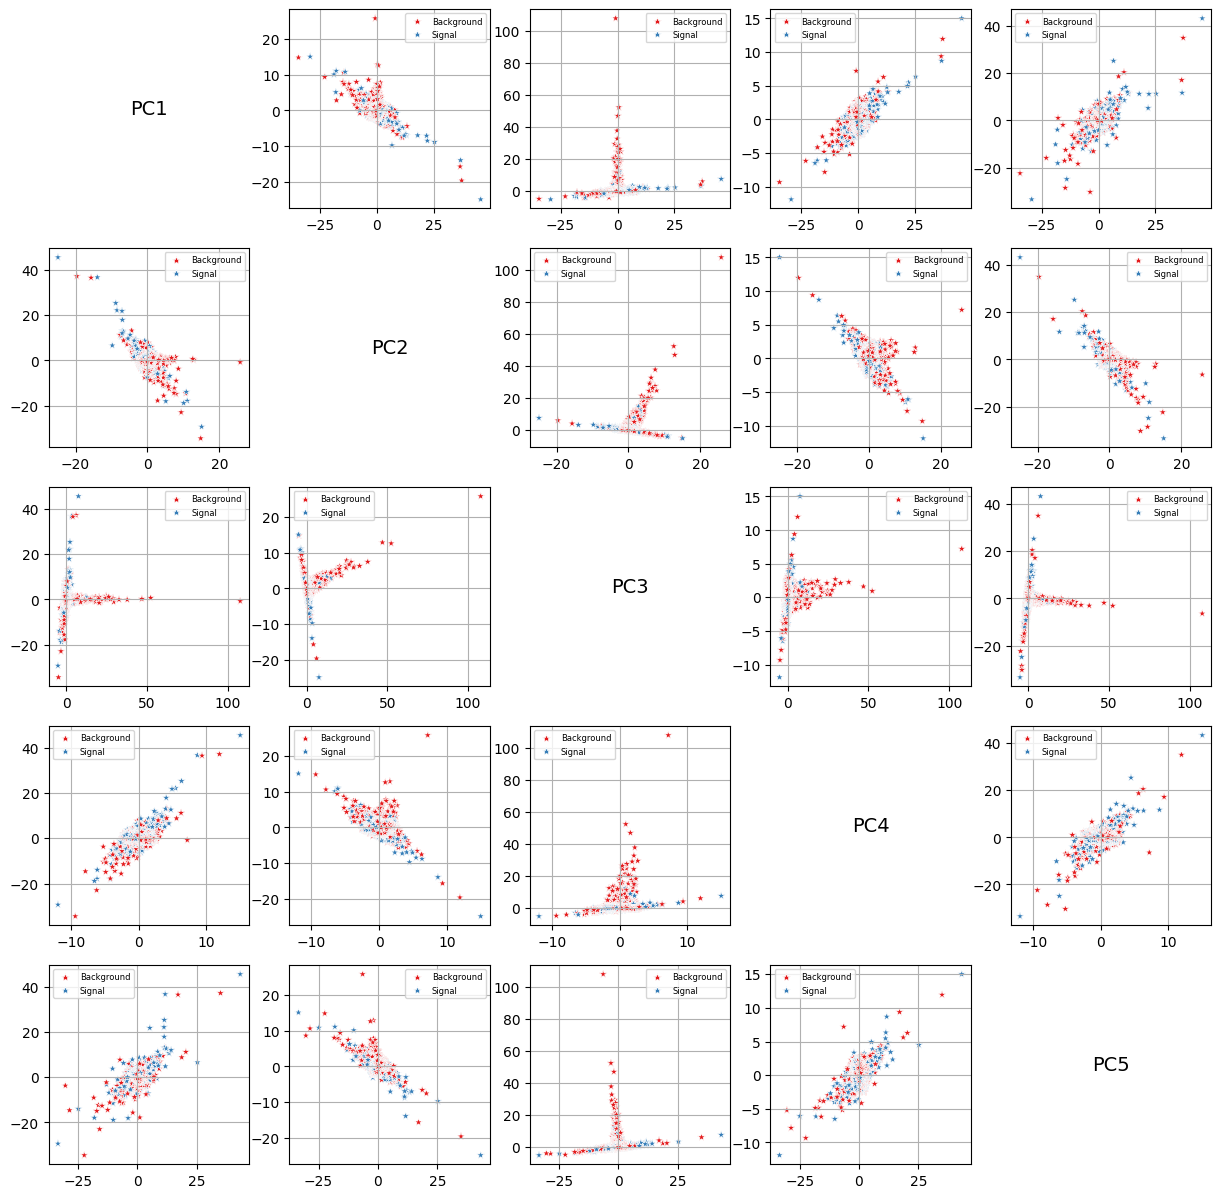

In [ ]:
import seaborn as sns

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
label = ['Background', 'Signal']
pca_df['target'] = [label[int(i)] for i in y_train[:50_000]]

# Biplot to visualize the first two principal components
fig, axes = plt.subplots(5,5,figsize=(15, 15))
for i in range(5):
  for j in range(5):
    if i != j:
      sns.scatterplot(x=f'PC{i+1}', y=f'PC{j+1}', hue='target', data=pca_df, palette='Set1', legend='full', ax=axes[i,j], marker='*')
      # plt.title('PCA Biplot')
      axes[i,j].grid(True, axis='both')
      axes[i,j].set_xlabel('')
      axes[i,j].set_ylabel('')
      legend = axes[i,j].legend(fontsize=6)
      # legend.remove()
    if i == j:
      axes[i, j].set_xlim((-1,1))
      axes[i, j].set_ylim((-1,1))
      axes[i, j].axis('off')
      axes[i, j].text(0,0, f'PC{i+1}',ha='center',va='center', fontsize=14)

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.savefig('plots/pca-events-plot.pdf', format='pdf')
plt.show()

In [ ]:
import numpy as np

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

feature_names = [r'$pT$', r'$\eta$', r'$\phi$', r'$d_z$', r'$d_z$']
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=feature_names)
print(loading_matrix)

             PC1       PC2       PC3       PC4       PC5
$pT$    0.000569  0.233321  0.969452  0.048491 -0.058245
$\eta$  0.355834  0.458599 -0.058737 -0.791998  0.179941
$\phi$  0.113029  0.789869 -0.207968  0.547822  0.141390
$d_z$   0.643565 -0.337112  0.109450  0.223544  0.640506
$d_z$   0.704839 -0.050568 -0.037715  0.107836 -0.698294


In [ ]:
def plot_correlation_circle(ax, loadings, pc1, pc2, labels):
    ax.axvline(0, color='grey', lw=1)
    ax.axhline(0, color='grey', lw=1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    # ax.set_xlabel(f'PC{pc1+1}')
    # ax.set_ylabel(f'PC{pc2+1}')
    # ax.set_title(f'PC{pc1+1} vs PC{pc2+1}')
    circle = plt.Circle((0, 0), 1, fill=False, color='black', linestyle='-', linewidth=1.5)
    ax.add_artist(circle)
    for i in range(loadings.shape[0]):
        ax.arrow(0, 0, loadings[i, pc1], loadings[i, pc2], color='black', alpha=0.5, head_width=0.05, head_length=0.07)
        ax.text(loadings[i, pc1]+0.1, loadings[i, pc2], labels[i], color='black', ha='center', va='center')

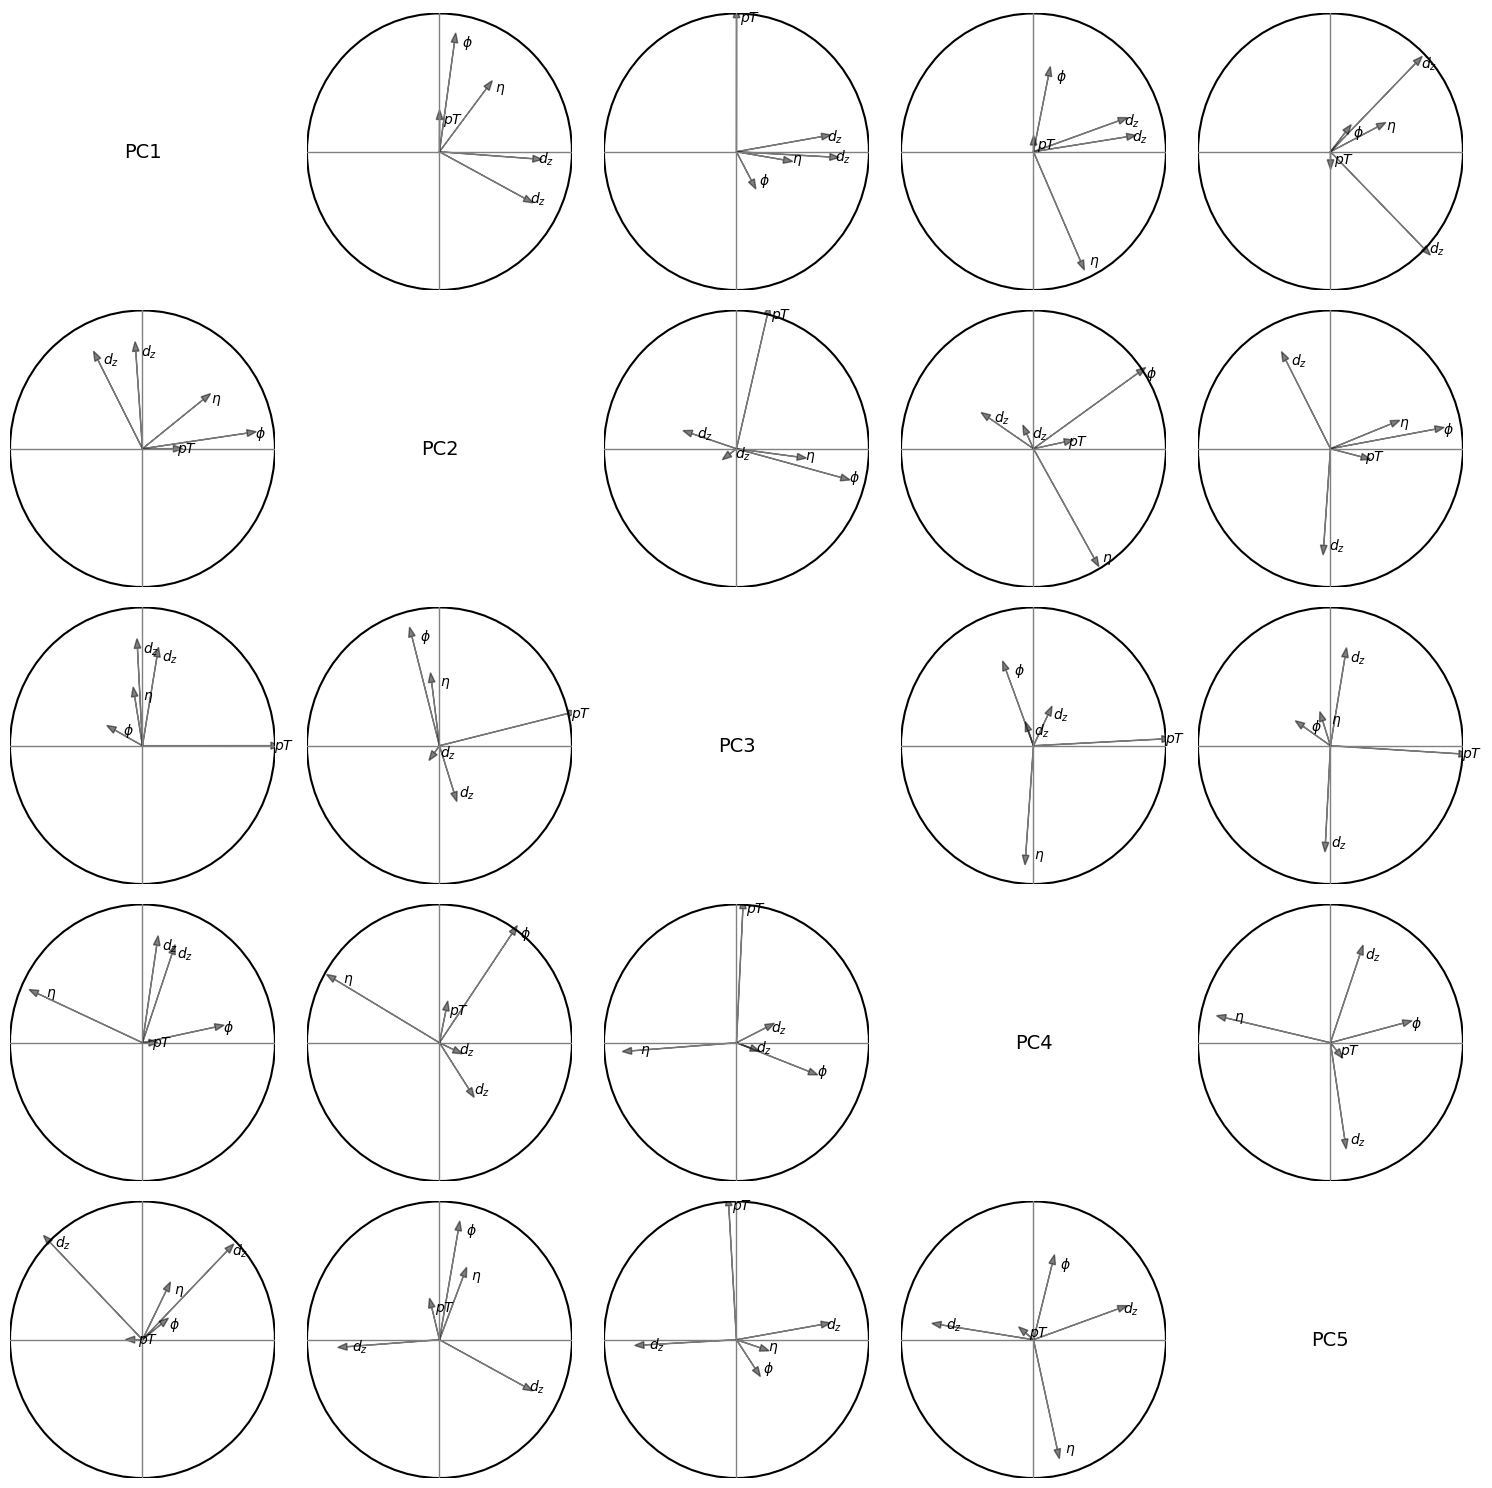

In [ ]:
# Determine number of components and create subplot grid
n_components = pca.n_components_
fig, axes = plt.subplots(n_components, n_components, figsize=(15, 15))

# Plot each pair of PCs in the grid
for i in range(n_components):
    for j in range(n_components):
        if i != j:
            plot_correlation_circle(axes[i, j], loadings, i, j, feature_names)
        # axes[i, j].set_aspect('equal')
        # axes[i, j].tick_params(axis='both', which='both', length=0)

        # Hide upper triangle and diagonal plots to avoid redundancy
        axes[i, j].axis('off')
        if i == j:
            axes[i, j].set_xlim((-1,1))
            axes[i, j].set_ylim((-1,1))

            axes[i, j].text(0,0, f'PC{i+1}',ha='center',va='center', fontsize=14)

plt.tight_layout()
plt.savefig('plots/pca-features-plot.pdf', format='pdf')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_scaled)
clusters = kmeans.predict(data_scaled)
pca_df['cluster'] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
pca_df['cluster'] = [label[1-i] for i in pca_df['cluster']]
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,target,cluster
0,1.035760,-0.631892,0.245534,-0.447495,-1.197668,Background,Background
1,-0.503338,-1.016806,0.576449,0.190219,-0.195033,Signal,Signal
2,-0.292420,-1.250882,0.088132,0.830408,-0.651799,Background,Signal
3,-0.203813,-0.256268,0.381361,1.378023,-0.465886,Signal,Signal
4,-0.213797,-0.373174,-0.140673,-0.682447,0.276170,Signal,Background


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(pca_df['target'], pca_df['cluster'])

In [ ]:
similarity = (cm[0,0] + cm[1,1])*100/cm.sum()
print('Similarity between cluster and target:', similarity,'%')

Similarity between cluster and target: 49.814 %


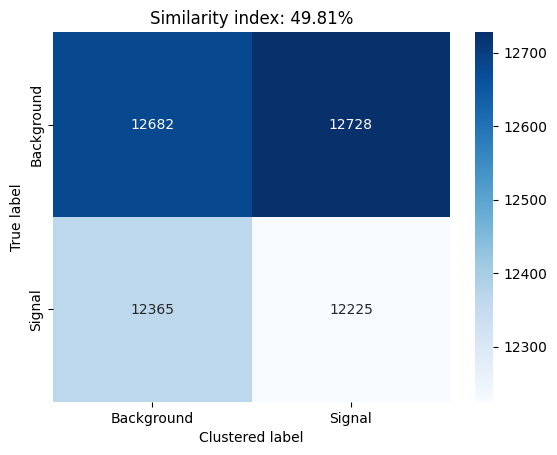

In [ ]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Signal"], yticklabels=label)
plt.title(f'Similarity index: {similarity:.2f}%')
plt.xlabel('Clustered label')
plt.ylabel('True label')
plt.show()